# Social Influence Maximization using Optimal Transport

## Global and Experimental Config Options

In [1]:
# global config options
LOG_LEVEL = "INFO"  # only DEBUG and INFO supported, anything else leads to CRITICAL
LOG_FILE = "./run.log"  # path relative to current working directory

# experiment config options
EDGE_PROB = 0.1
NUM_SEEDS = 2  # check against the graph loaded
REALIZATIONS = 1000
BIN_SIZE = 10  # for the 2D distribution plots

In [2]:
# doesn't work well to adapt to runtime library changes
# might need to restart kernel and rerun, to accomodate library changes
%load_ext autoreload
%autoreload 2

In [3]:
# global imports
import os
from pprint import pprint

In [4]:
PROJECT_ROOT = !pwd
PROJECT_ROOT = PROJECT_ROOT[0]
os.environ["PROJECT_ROOT"] = PROJECT_ROOT
print("Project Root:", PROJECT_ROOT)

Project Root: /home/codeviser/dev/sim_dev/fairness-in-social-influence-maximization-via-optimal-transport


In [ ]:
os.environ["LOG_LEVEL"] = LOG_LEVEL
print("Log level for libraries:", LOG_LEVEL)

os.environ["LOG_FILE"] = PROJECT_ROOT + "/" + LOG_FILE
print("Library logs are present at", os.environ["LOG_FILE"])

Log level for libraries: INFO
Library logs are present at /home/codeviser/dev/sim_dev/fairness-in-social-influence-maximization-via-optimal-transport/./run.log


## Modular experiment runs (exploring each library module individually)

### 1. Loading the Graph from persistent disk

In [6]:
from utils.data_utils import load_graph_from_edgelist, load_graph_node_features
from utils.graph_utils import log_social_graph_data_summary

In [7]:
G = load_graph_from_edgelist()  # nodes are string, edges are between strings
node_feats = load_graph_node_features()  # node features are ints for now
assert set(G.nodes()) == set(node_feats.keys())
log_social_graph_data_summary(G, node_feats)

### 2. Select Early Adopters based on Some Algo (and print the random graph)

In [8]:
from early_seed_selection.node_centrality import greedy_node_reach as degree_seed_selector
from utils.graph_utils import draw_social_graph

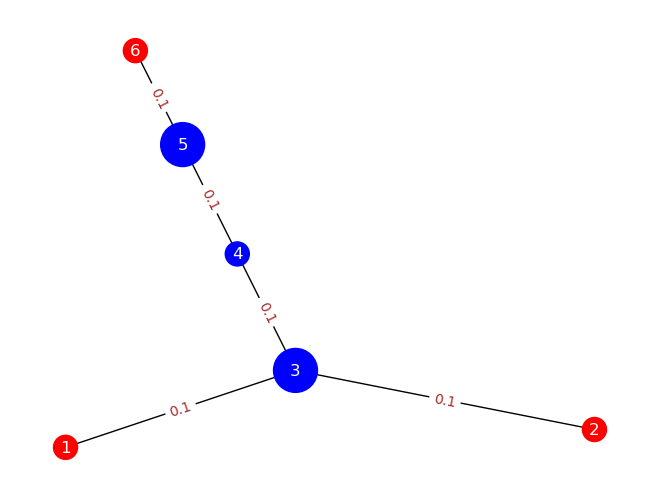

In [9]:
seedset = degree_seed_selector.propose_seedset(G,
                                               node_feats,
                                               NUM_SEEDS,
                                               EDGE_PROB,
                                               num_realizations=1000)
# draw_random_graph(G, EDGE_PROB, seedset)
draw_social_graph(G,
                  EDGE_PROB,
                  seedset=seedset,
                  node_feats=node_feats,
                  plot_plain=False)

### 3. Propagate (many times) based on a chosen prop-algo

In [10]:
from propagation.propagate import propagate
from propagation.multiple_propagate import repeated_propagate
from utils.graph_utils import get_largest_graph_diameter

In [ ]:
prop_info, seed_info, group_info = propagate(
    G,
    node_feats,
    EDGE_PROB,
    seedset,
    time_horizon=get_largest_graph_diameter(G) // 1)

print("1-step propagation results, node: (is_reached, (seed, time))")
pprint(prop_info)

print(
    "seed results, seed: [total_reach, {group_id: [group_reach, time_taken], ...}]"
)
pprint(seed_info)

print("group results, group_id: [total_reach, total_time_taken]")
print(group_info)

1-step propagation results, node: (is_reached, (seed, time))
{'1': (False, None),
 '2': (False, None),
 '3': (True, ('3', 0)),
 '4': (False, None),
 '5': (True, ('5', 0)),
 '6': (True, ('5', 1))}
seed results, seed: [total_reach, {group_id: [group_reach, time_taken], ...}]
{'3': [1, {0: [0, 0], 1: [1, 0]}], '5': [2, {0: [1, 1], 1: [1, 0]}]}
group results, group_id: [total_reach, total_time_taken]
{0: (1, 1), 1: (2, 0)}


In [12]:
runs_prop_info, runs_seed_info, runs_group_info = repeated_propagate(
    propagate,
    REALIZATIONS,
    G=G,
    node_feats=node_feats,
    edge_prob=EDGE_PROB,
    seedset=seedset,
    time_horizon=get_largest_graph_diameter(G) // 1)

### 4. Generate metric scores based on experiments

In [13]:
from metrics.seed_metrics import calculate_seedset_performance

In [14]:
aggr_seed_perf = calculate_seedset_performance(runs_seed_info)
print(
    "Multi run seed performance, seed: [total_reach, {group_id: [group_reach, time_taken], ...}]"
)
pprint(aggr_seed_perf)

Multi run seed performance, seed: [total_reach, {group_id: [group_reach, time_taken], ...}]
{'3': [1.318,
       {0: [0.213, 1.1408450704225352], 1: [1.105, 0.19004524886877827]}],
 '5': [1.197, {0: [0.093, 1.0], 1: [1.104, 0.18840579710144928]}]}


### 5. Create distribution sample points

In [15]:
from metrics.group_metrics import calculate_groupwise_dist

In [16]:
reach_per_group_per_run = calculate_groupwise_dist(runs_group_info, node_feats)

### 6. Plot 2-D histograms

In [17]:
from plots.plot_2d import (
    plot_groupwise_outreach_histogram,
    plot_2d_hist_binnings,
    plot_2d_cost_matrix,
)

In [18]:
plot_hist_in_bins = plot_groupwise_outreach_histogram(reach_per_group_per_run,
                                                      BIN_SIZE,
                                                      return_only_bins=True)

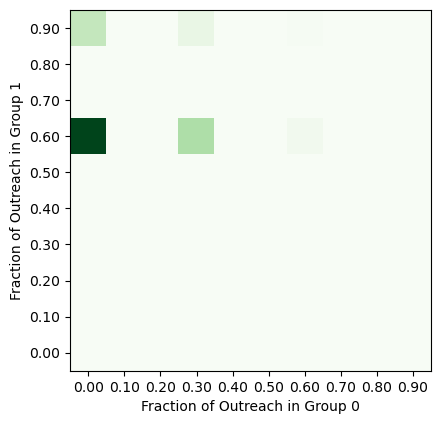

In [19]:
# another way (used for rest of the plots below)
bin_edges = plot_hist_in_bins[1]
plot_2d_hist_binnings(plot_hist_in_bins[0], bin_edges, rot=True)

### 7. Create target OT 2D distributions

In [20]:
from utils.ot_utils import (
    create_ideal_fair_and_efficient_2d_target_dist,
    create_fair_and_efficient_2d_dist,
    create_fair_and_efficient_2d_cost_matrix,
    calculate_emd_matrix,
    unroll_dist_from_hist_bins,
)

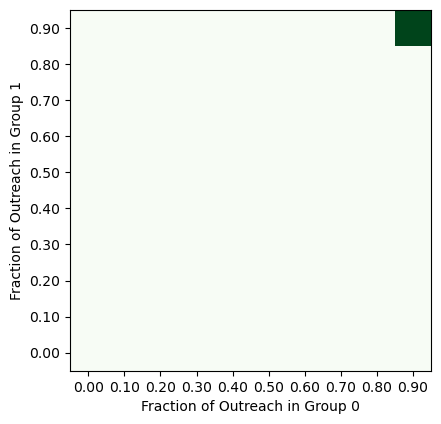

In [21]:
target_dist = create_ideal_fair_and_efficient_2d_target_dist(BIN_SIZE)
plot_2d_hist_binnings(target_dist[0], bin_edges, rot=False)

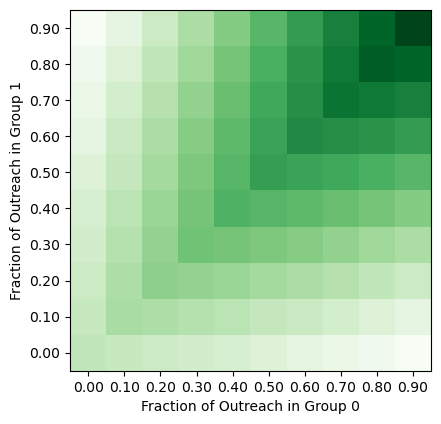

In [22]:
# cost landscape when beta-fairness is taken into account (beta=1/(1+1) = 0.5)
plot_2d_hist_binnings(
    create_fair_and_efficient_2d_dist(BIN_SIZE, True, 1.0, True, 1.0)[0],
    bin_edges,
    rot=False,
)

### 8. Generate OT Cost Matrix and Calculate OT Score

Creating cost matrix for OT


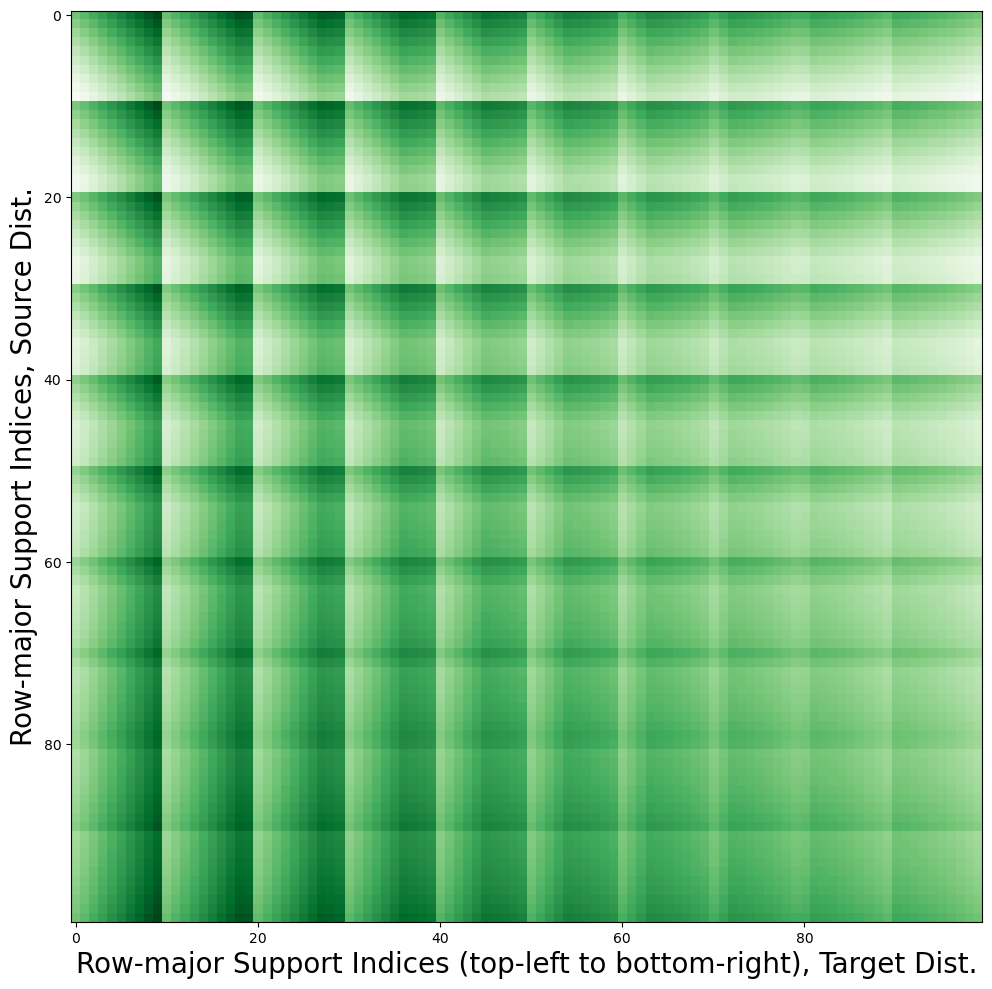

Solving EMD
Transport plot for each 2d space chunk


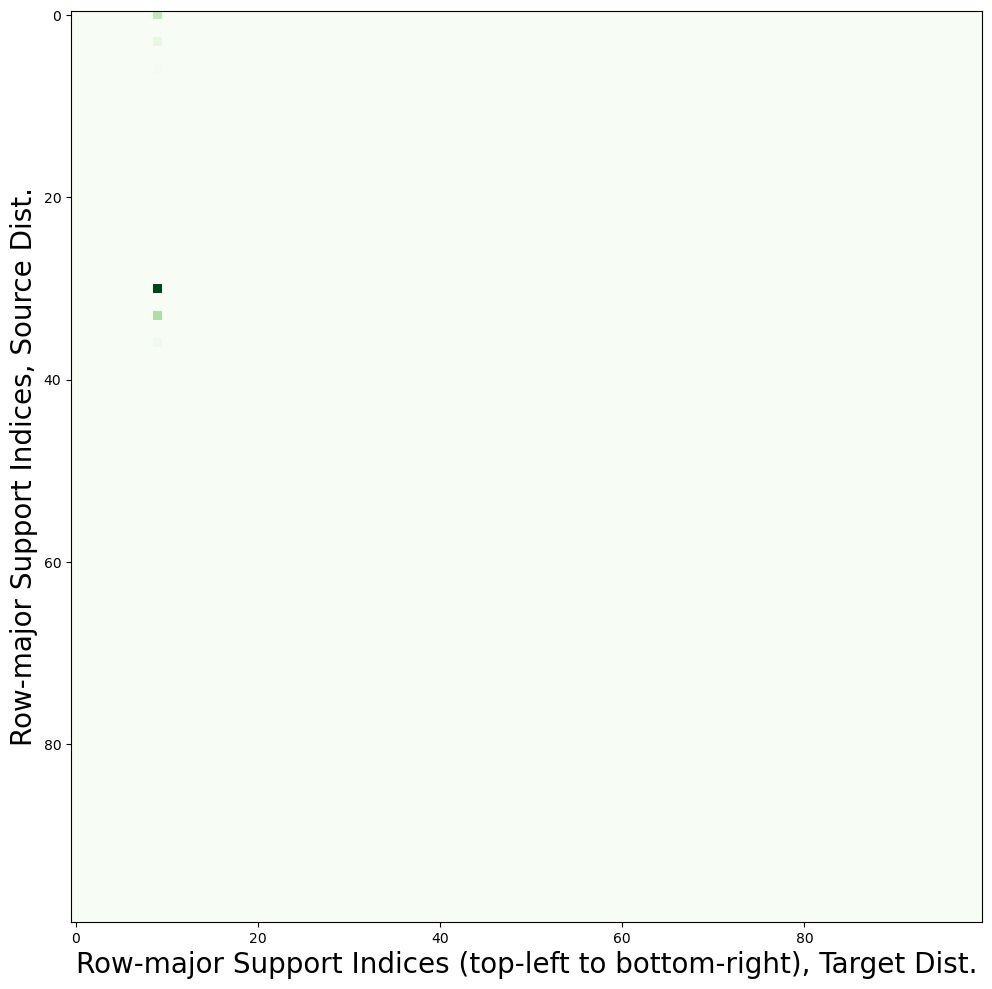

Final Transport Score: 13.960292649517903


In [23]:
print("Creating cost matrix for OT")
M, scale_k = create_fair_and_efficient_2d_cost_matrix(
    BIN_SIZE, True, 1.0, True,
    1.0)  # 1.0, 1.0 are relative weights on fairness and efficiency
plot_2d_cost_matrix(M)

print("Solving EMD")
score, res_dict = calculate_emd_matrix(
    unroll_dist_from_hist_bins(plot_hist_in_bins[0]), target_dist[2], M,
    scale_k)

print("Transport plot for each 2d space chunk")
plot_2d_cost_matrix(res_dict["G"])

print("Final Transport Score:", score)

## Easy experiment Mode

In [24]:
from pipeline import social_experiment as exp
from early_seed_selection.node_centrality import greedy_node_reach, node_degree
from propagation.propagate import propagate
from utils.ot_utils import create_ideal_fair_and_efficient_2d_target_dist

In [25]:
custom_input = exp.DEFAULT_INPUT
custom_input["BIN_SIZE"] = 100
custom_pipeline = exp.DEFAULT_PIPELINE_MOD
custom_pipeline["seed_selector"] = greedy_node_reach.propose_seedset
custom_pipeline["propagate"] = propagate
custom_pipeline[
    "target_dist"] = create_ideal_fair_and_efficient_2d_target_dist(
        custom_input["BIN_SIZE"])

In [26]:
%%capture
custom_out = exp.run_experiment(input=custom_input,
                                pipeline_mod=custom_pipeline)

In [ ]:
print(custom_out)

{'ot_score': 140.1422396553451, 'group_metrics': {0: 0.20666666666666667, 1: 0.7856666666666665}}


## Dataset Investigation

### Instagram

In [28]:
from data.instagram_ds import normalize_ds
from pipeline import social_experiment as exp
from early_seed_selection.node_centrality import greedy_node_reach, node_degree
from propagation.propagate import propagate
from utils.ot_utils import create_ideal_fair_and_efficient_2d_target_dist

In [29]:
normalize_ds.create_and_dump_graph_info(num_truncated_nodes=5000)

In [30]:
custom_input = {
    "edgelist_file": PROJECT_ROOT + '/data/instagram_ds/graph_edges.csv',
    "node_feat_file":
    PROJECT_ROOT + '/data/instagram_ds/graph_node_features.csv',
    "EDGE_PROB": 0.5,
    "NUM_SEEDS": 10,
    "REALIZATIONS": 1000,
    "BIN_SIZE": 100
}
custom_pipeline = {
    "seed_selector":
    node_degree.propose_seedset,
    "propagate":
    propagate,
    "target_dist":
    create_ideal_fair_and_efficient_2d_target_dist(custom_input["BIN_SIZE"]),
    "plot_graph":
    False
}
# largest diam = 16

In [31]:
%%capture
custom_out = exp.run_experiment(input=custom_input,
                                pipeline_mod=custom_pipeline)

### [Heavy Compute] Instagram: Breadth Analysis

In [32]:
%%capture

from multiprocessing import Pool, freeze_support
from copy import deepcopy

freeze_support()

edge_probs_list = [0.01, 0.5, 0.99]
frac_seeds_list = [0.3, 0.9]
seed_selector_lists = [
    greedy_node_reach.propose_seedset, node_degree.propose_seedset
]

run_configs = []
for edge_prob in edge_probs_list:
    for frac_seeds in frac_seeds_list:
        for seed_selector in seed_selector_lists:
            run_cfg_input = deepcopy(custom_input)
            run_cfg_pipeline = deepcopy(custom_pipeline)

            run_cfg_input["EDGE_PROB"] = edge_prob
            run_cfg_input["FRAC_SEEDS"] = frac_seeds

            run_cfg_pipeline["seed_selector"] = seed_selector

            run_configs.append((run_cfg_input, run_cfg_pipeline))

with Pool() as pool:
    pool.starmap(exp.run_experiment, run_configs)

# exp.run_experiment(input=custom_input, pipeline_mod=custom_pipeline)

### Deezer

In [33]:
from data.deezer_ds import normalize_ds
from pipeline import social_experiment as exp
from early_seed_selection.node_centrality import greedy_node_reach, node_degree
from propagation.propagate import propagate
from utils.ot_utils import create_ideal_fair_and_efficient_2d_target_dist

In [34]:
normalize_ds.create_and_dump_graph_info(num_truncated_nodes=2000)

In [35]:
custom_input = {
    "edgelist_file": PROJECT_ROOT + '/data/deezer_ds/graph_edges.csv',
    "node_feat_file": PROJECT_ROOT + '/data/deezer_ds/graph_node_features.csv',
    "EDGE_PROB": 0.5,
    "NUM_SEEDS": 15,
    "REALIZATIONS": 1000,
    "BIN_SIZE": 100
}
custom_pipeline = {
    "seed_selector":
    greedy_node_reach.propose_seedset,
    "propagate":
    propagate,
    "target_dist":
    create_ideal_fair_and_efficient_2d_target_dist(custom_input["BIN_SIZE"]),
    "plot_graph":
    False
}
# largest diam: 25

In [36]:
%%capture
custom_out = exp.run_experiment(input=custom_input,
                                pipeline_mod=custom_pipeline)

### [Heavy Compute] Deezer Breadth Analysis

In [37]:
%%capture

# Total nodes, edges in sub-graph, 18442, 46172
# num seeds = 922 (5%)
# Avg node degree, 5

from multiprocessing import Pool, freeze_support
from copy import deepcopy

freeze_support()

edge_probs_list = [0.01, 0.1, 0.3, 0.5, 0.7, 0.99]
frac_seeds_list = [0.005, 0.05]
seed_selector_lists = [
    greedy_node_reach.propose_seedset, node_degree.propose_seedset
]

run_configs = []
for edge_prob in edge_probs_list:
    for frac_seeds in frac_seeds_list:
        for seed_selector in seed_selector_lists:
            run_cfg_input = deepcopy(custom_input)
            run_cfg_pipeline = deepcopy(custom_pipeline)

            run_cfg_input["EDGE_PROB"] = edge_prob
            run_cfg_input["FRAC_SEEDS"] = frac_seeds

            run_cfg_pipeline["seed_selector"] = seed_selector

            run_configs.append((run_cfg_input, run_cfg_pipeline))

with Pool() as pool:
    pool.starmap(exp.run_experiment, run_configs)

### APS

In [38]:
from data.aps_ds import normalize_ds
from pipeline import social_experiment as exp
from early_seed_selection.node_centrality import greedy_node_reach, node_degree
from propagation.propagate import propagate
from utils.ot_utils import create_ideal_fair_and_efficient_2d_target_dist

In [39]:
normalize_ds.create_and_dump_graph_info(num_truncated_nodes=4 *
                                        10**4)  # irrelevant argument

In [40]:
ds_name = "aps_ds"  # graph lasrgest diameter = 26
custom_input = {
    "edgelist_file": PROJECT_ROOT + '/data/' + ds_name + '/graph_edges.csv',
    "node_feat_file":
    PROJECT_ROOT + '/data/' + ds_name + '/graph_node_features.csv',
    "EDGE_PROB": 0.3,
    "NUM_SEEDS": 6,
    "REALIZATIONS": 1000,
    "BIN_SIZE": 100
}
custom_pipeline = {
    "seed_selector":
    node_degree.propose_seedset,
    "propagate":
    propagate,
    "target_dist":
    create_ideal_fair_and_efficient_2d_target_dist(custom_input["BIN_SIZE"]),
    "plot_graph":
    False
}

In [41]:
%%capture
custom_out = exp.run_experiment(input=custom_input,
                                pipeline_mod=custom_pipeline)

### [Heavy Compute] APS Breadth Analysis

In [42]:
%%capture

# Total nodes, 1281
# Total edges, 3064
# num seeds = 64 (5%)
# Avg node degree, 4

from multiprocessing import Pool, freeze_support
from copy import deepcopy

freeze_support()

edge_probs_list = [0.01, 0.1, 0.3, 0.5, 0.7, 0.99]
frac_seeds_list = [0.005, 0.05]
seed_selector_lists = [
    greedy_node_reach.propose_seedset, node_degree.propose_seedset
]

run_configs = []
for edge_prob in edge_probs_list:
    for frac_seeds in frac_seeds_list:
        for seed_selector in seed_selector_lists:
            run_cfg_input = deepcopy(custom_input)
            run_cfg_pipeline = deepcopy(custom_pipeline)

            run_cfg_input["EDGE_PROB"] = edge_prob
            run_cfg_input["FRAC_SEEDS"] = frac_seeds

            run_cfg_pipeline["seed_selector"] = seed_selector

            run_configs.append((run_cfg_input, run_cfg_pipeline))

with Pool() as pool:
    pool.starmap(exp.run_experiment, run_configs)

### Indian Villages Dataset (on languages)

In [43]:
from data.ind_villages_ds import normalize_ds
from pipeline import social_experiment as exp
from early_seed_selection.node_centrality import greedy_node_reach, node_degree
from propagation.propagate import propagate
from utils.ot_utils import create_ideal_fair_and_efficient_2d_target_dist

In [44]:
normalize_ds.create_and_dump_graph_info()

In [45]:
ds_name = "ind_villages_ds"  # largest dima= 13
custom_input = {
    "edgelist_file": PROJECT_ROOT + '/data/' + ds_name + '/graph_edges.csv',
    "node_feat_file":
    PROJECT_ROOT + '/data/' + ds_name + '/graph_node_features.csv',
    "EDGE_PROB": 0.1,
    "NUM_SEEDS": 2,
    "REALIZATIONS": 10000,
    "BIN_SIZE": 100
}
custom_pipeline = {
    "seed_selector":
    greedy_node_reach.propose_seedset,
    "propagate":
    propagate,
    "target_dist":
    create_ideal_fair_and_efficient_2d_target_dist(custom_input["BIN_SIZE"]),
    "plot_graph":
    False
}

In [46]:
custom_out = exp.run_experiment(input=custom_input,
                                pipeline_mod=custom_pipeline)

### Add Health Dataset (similar to Instagram but smaller)

In [47]:
# largest diam= 10

### [Heavy Compute, explicit dataset installation] DBLP

In [48]:
from data.dblp_ds import normalize_ds
from pipeline import social_experiment as exp
from early_seed_selection.node_centrality import greedy_node_reach, node_degree
from propagation.propagate import propagate
from utils.ot_utils import create_ideal_fair_and_efficient_2d_target_dist

In [49]:
normalize_ds.create_and_dump_graph_info(num_truncated_nodes=50000)

In [50]:
ds_name = "dblp_ds"
custom_input = {
    "edgelist_file": PROJECT_ROOT + '/data/' + ds_name + '/graph_edges.csv',
    "node_feat_file":
    PROJECT_ROOT + '/data/' + ds_name + '/graph_node_features.csv',
    "EDGE_PROB": 0.02,
    "NUM_SEEDS": 2,
    "REALIZATIONS": 1000,
    "BIN_SIZE": 1000
}
custom_pipeline = {
    "seed_selector":
    greedy_node_reach.propose_seedset,
    "propagate":
    propagate,
    "target_dist":
    create_ideal_fair_and_efficient_2d_target_dist(custom_input["BIN_SIZE"]),
    "plot_graph":
    False
}

In [ ]:
# custom_out = exp.run_experiment(input=custom_input, pipeline_mod=custom_pipeline)

### High School (gender)

In [52]:
from data.high_school_ds import normalize_ds
from pipeline import social_experiment as exp
from early_seed_selection.node_centrality import greedy_node_reach, node_degree
from propagation.propagate import propagate
from utils.ot_utils import create_ideal_fair_and_efficient_2d_target_dist

In [53]:
normalize_ds.create_and_dump_graph_info()

In [54]:
ds_name = "high_school_ds"  # largest diam is 10
custom_input = {
    "edgelist_file": PROJECT_ROOT + '/data/' + ds_name + '/graph_edges.csv',
    "node_feat_file":
    PROJECT_ROOT + '/data/' + ds_name + '/graph_node_features.csv',
    "EDGE_PROB": 0.1,
    "NUM_SEEDS": 2,
    "REALIZATIONS": 1000,
    "BIN_SIZE": 100
}
custom_pipeline = {
    "seed_selector":
    greedy_node_reach.propose_seedset,
    "propagate":
    propagate,
    "target_dist":
    create_ideal_fair_and_efficient_2d_target_dist(custom_input["BIN_SIZE"]),
    "plot_graph":
    False
}

In [55]:
custom_out = exp.run_experiment(input=custom_input,
                                pipeline_mod=custom_pipeline)

### Antelope Valley (race)

In [56]:
from data.antelope_valley_ds import normalize_ds
from pipeline import social_experiment as exp
from early_seed_selection.node_centrality import greedy_node_reach, node_degree
from propagation.propagate import propagate
from utils.ot_utils import create_ideal_fair_and_efficient_2d_target_dist

In [57]:
normalize_ds.create_and_dump_graph_info(ds_idx=12)

In [58]:
ds_name = "antelope_valley_ds"  # largest diam is <variable per dataset index>, ds_idx_to_largest_diam: {12: 13, 22: 14, 0:12, 1: 13, 2: 14, 16: 13}
custom_input = {
    "edgelist_file": PROJECT_ROOT + '/data/' + ds_name + '/graph_edges.csv',
    "node_feat_file":
    PROJECT_ROOT + '/data/' + ds_name + '/graph_node_features.csv',
    "EDGE_PROB": 0.3,
    "NUM_SEEDS": 4,
    "REALIZATIONS": 1000,
    "BIN_SIZE": 100
}
custom_pipeline = {
    "seed_selector":
    greedy_node_reach.propose_seedset,
    "propagate":
    propagate,
    "target_dist":
    create_ideal_fair_and_efficient_2d_target_dist(custom_input["BIN_SIZE"]),
    "plot_graph":
    False
}

In [59]:
custom_out = exp.run_experiment(input=custom_input,
                                pipeline_mod=custom_pipeline)

## Seed Selection Stochastic Descent (S3D):: Experimentation with SIM modules

In [60]:
BIN_SIZE = 100

### 1. Routine build-up using necessary steps

In [61]:
from utils.data_utils import load_graph_from_edgelist, load_graph_node_features
from utils.graph_utils import log_social_graph_data_summary

In [62]:
G = load_graph_from_edgelist(PROJECT_ROOT + "/data/aps_ds/graph_edges.csv"
                             )  # nodes are string, edges are between strings
node_feats = load_graph_node_features(
    PROJECT_ROOT +
    "/data/aps_ds/graph_node_features.csv")  # node features are ints for now
assert set(G.nodes()) == set(node_feats.keys())
log_social_graph_data_summary(G, node_feats)

In [63]:
from early_seed_selection.node_centrality import node_degree as degree_seed_selector
from utils.graph_utils import draw_social_graph

In [64]:
NUM_SEEDS = 7
EDGE_PROB = 0.5

seedset = degree_seed_selector.propose_seedset(G,
                                               node_feats,
                                               NUM_SEEDS,
                                               EDGE_PROB,
                                               num_realizations=1000)
print("Initial seedset:", seedset)

Initial seedset: ['10.1103/PhysRevLett.52.1583', '10.1103/PhysRevLett.49.957', '10.1103/PhysRevLett.67.937', '10.1103/PhysRevLett.53.722', '10.1103/PhysRevLett.60.2677', '10.1103/PhysRevLett.53.111', '10.1103/PhysRevLett.52.2103']


### 2. Routine to get OT score per seed on a Random Graph

In [65]:
lone_seedset = [seedset[-1]]  # need to find an alternative to this seedset
print("target_seed: ", lone_seedset[0])

target_seed:  10.1103/PhysRevLett.52.2103


In [66]:
from propagation.propagate import propagate
from propagation.multiple_propagate import repeated_propagate
from utils.graph_utils import get_largest_graph_diameter

In [67]:
runs_prop_info, runs_seed_info, runs_group_info = repeated_propagate(
    propagate,
    REALIZATIONS,
    G=G,
    node_feats=node_feats,
    edge_prob=EDGE_PROB,
    seedset=lone_seedset,
    time_horizon=get_largest_graph_diameter(G) // 1)

In [68]:
from metrics.seed_metrics import calculate_seedset_performance

In [69]:
aggr_seed_perf = calculate_seedset_performance(runs_seed_info)
print(
    "Multi run seed performance, seed: [total_reach, {group_id: [group_reach, time_taken], ...}]"
)
pprint(aggr_seed_perf)

Multi run seed performance, seed: [total_reach, {group_id: [group_reach, time_taken], ...}]
{'10.1103/PhysRevLett.52.2103': [622.495,
                                 {0: [490.199, 4628.089398387186],
                                  1: [132.296, 2414.692454798331]}]}


In [70]:
from metrics.group_metrics import calculate_groupwise_dist

In [71]:
reach_per_group_per_run = calculate_groupwise_dist(runs_group_info, node_feats)

In [72]:
from plots.plot_2d import (
    plot_groupwise_outreach_histogram,
    plot_2d_hist_binnings,
    plot_2d_cost_matrix,
)

In [73]:
plot_hist_in_bins = plot_groupwise_outreach_histogram(reach_per_group_per_run,
                                                      BIN_SIZE,
                                                      return_only_bins=True)

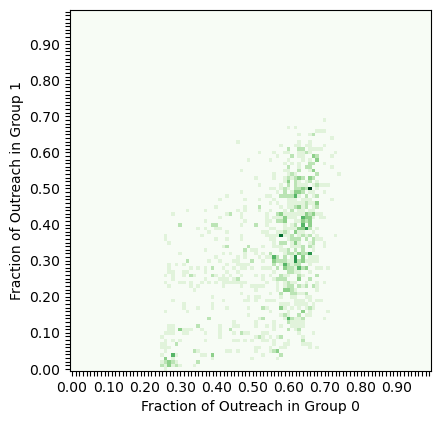

In [74]:
# another way (used for rest of the plots below)
bin_edges = plot_hist_in_bins[1]
plot_2d_hist_binnings(plot_hist_in_bins[0], bin_edges, rot=True)

In [75]:
from utils.ot_utils import (
    create_ideal_fair_and_efficient_2d_target_dist,
    create_fair_and_efficient_2d_dist,
    create_fair_and_efficient_2d_cost_matrix,
    calculate_emd_matrix,
    unroll_dist_from_hist_bins,
)

In [76]:
target_dist = create_ideal_fair_and_efficient_2d_target_dist(BIN_SIZE)
# target_dist = create_fair_and_efficient_2d_dist(BIN_SIZE, True, 1.0, False, 1.0)

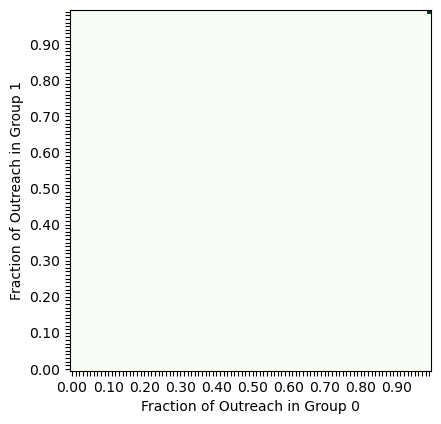

In [77]:
plot_2d_hist_binnings(target_dist[0], bin_edges, rot=False)

Creating cost matrix for OT


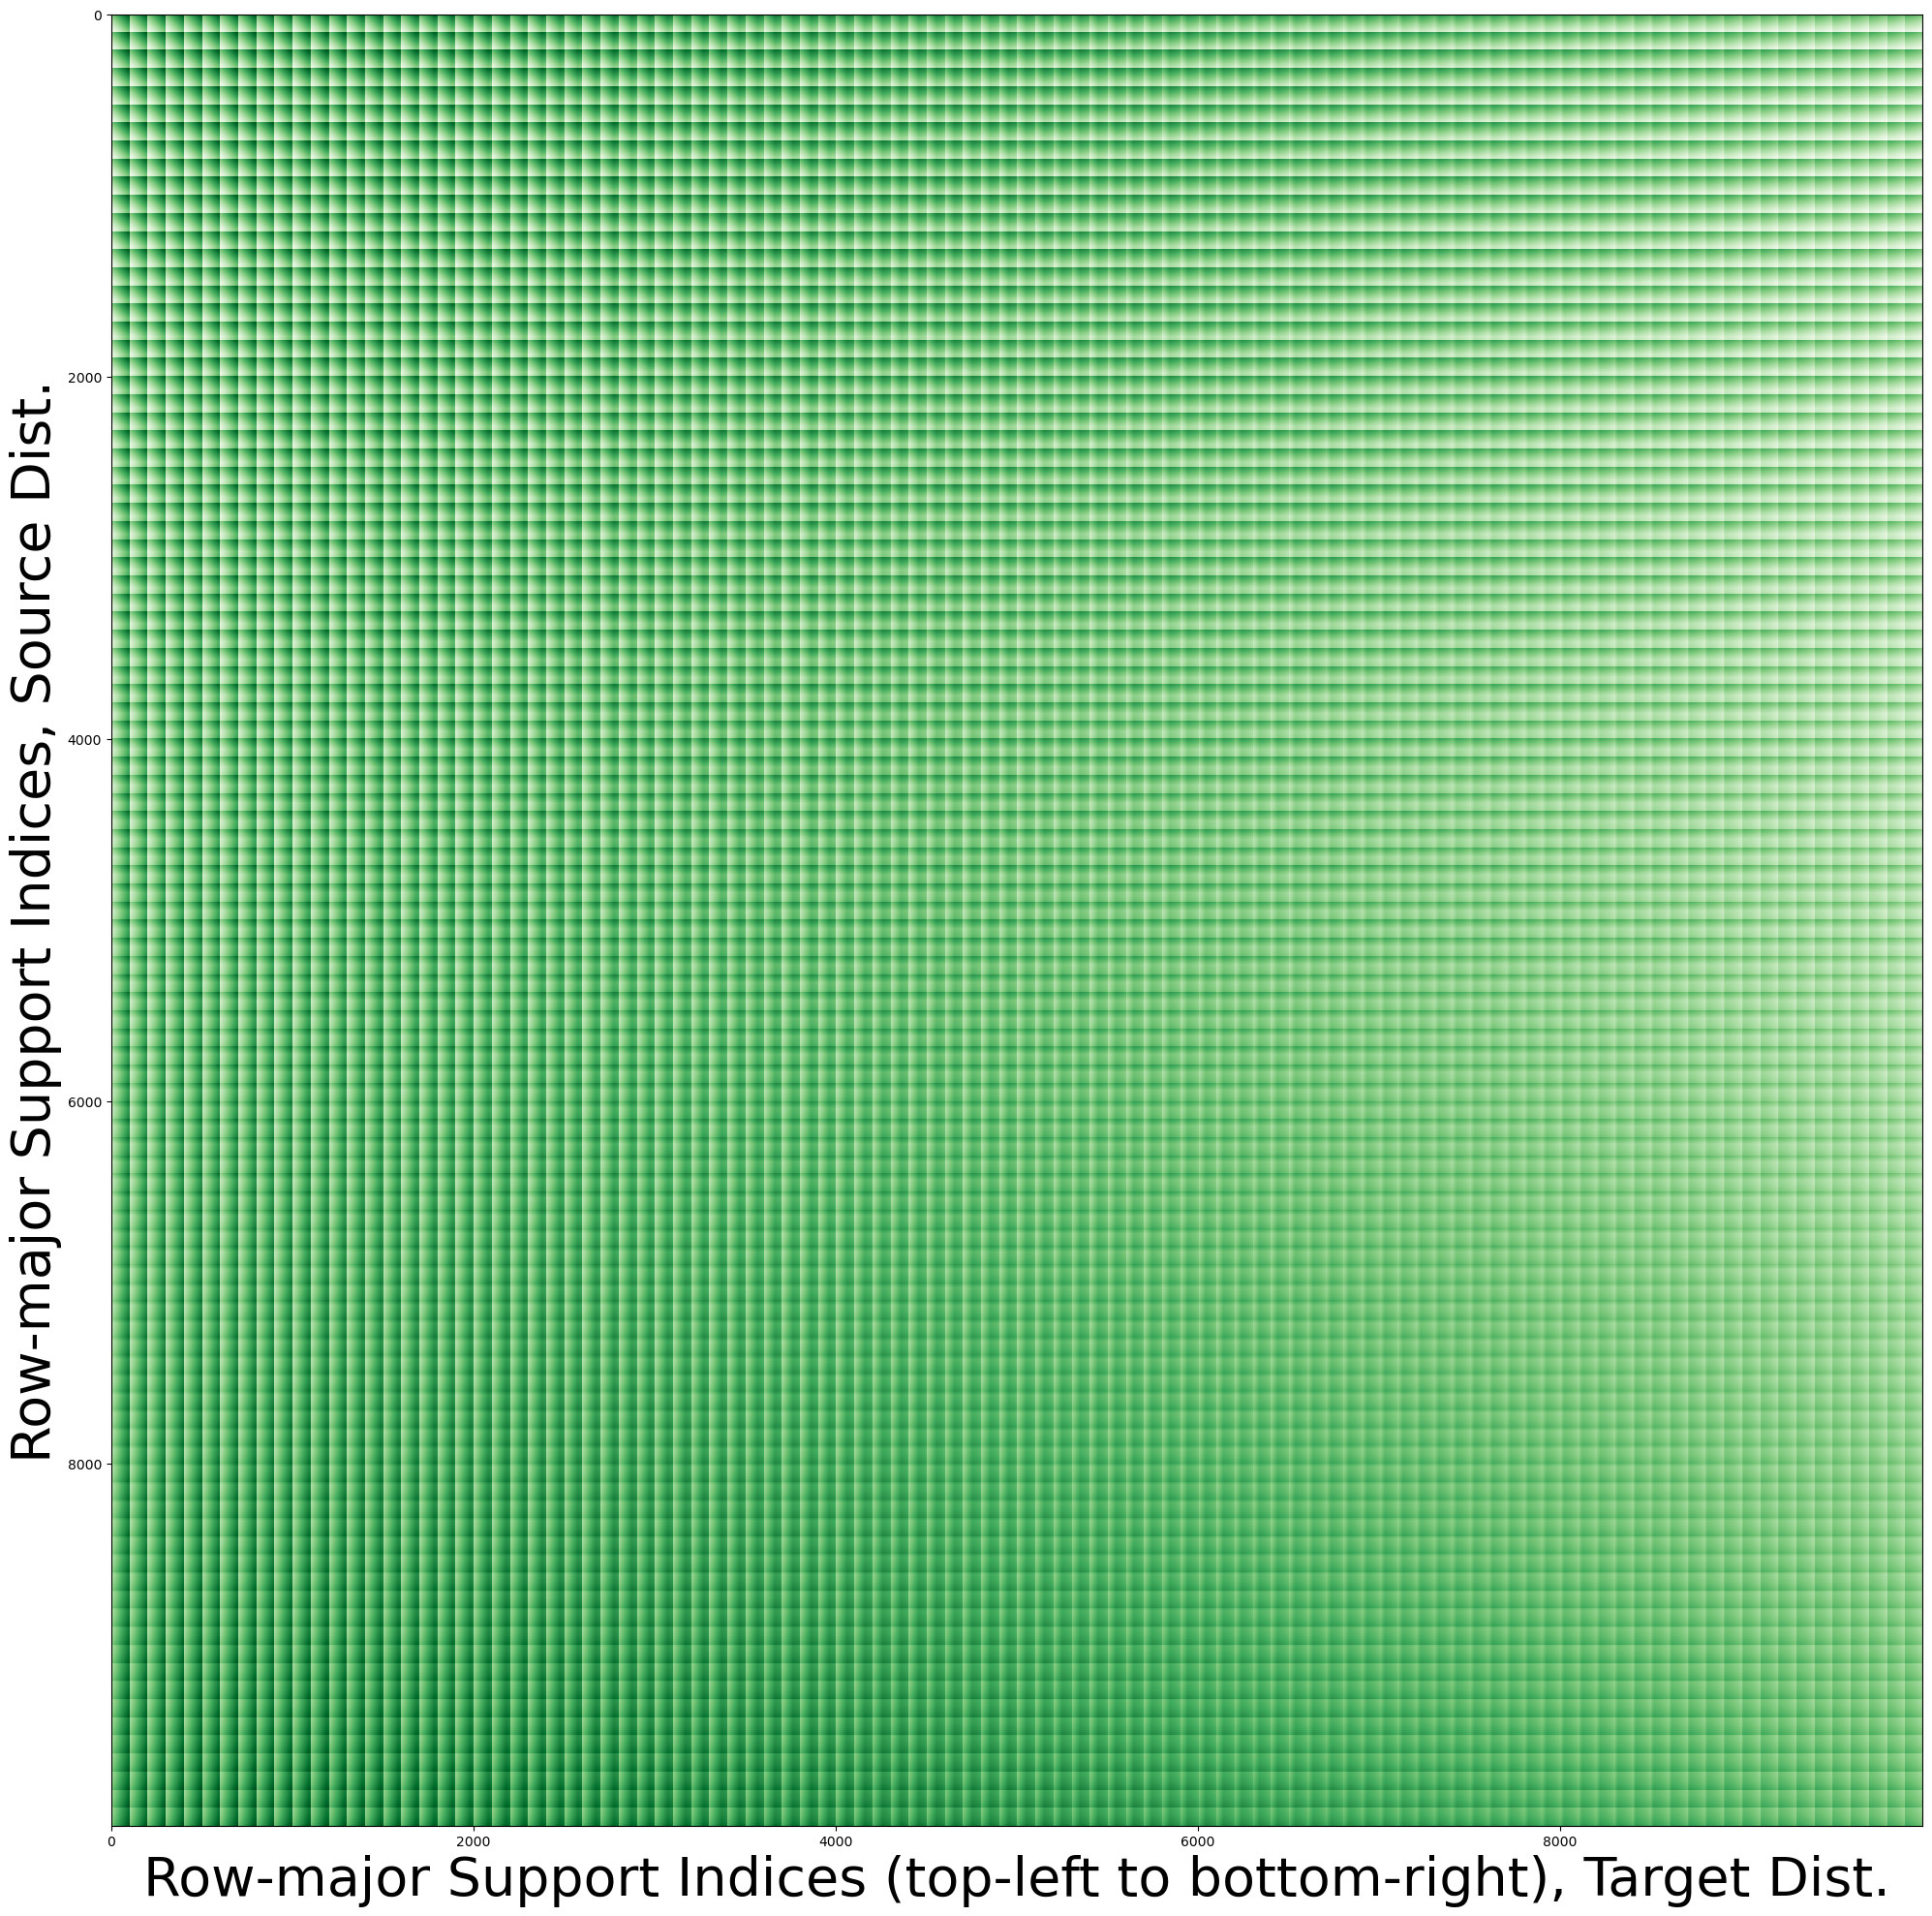

Solving EMD
Final Transport Score: 104.26817139303323


In [78]:
print("Creating cost matrix for OT")
M, scale_k = create_fair_and_efficient_2d_cost_matrix(
    BIN_SIZE, True, 1.0, True,
    1.0)  # 1.0, 1.0 are relative weights on fairness and efficiency
plot_2d_cost_matrix(M)

print("Solving EMD")
score, res_dict = calculate_emd_matrix(
    unroll_dist_from_hist_bins(plot_hist_in_bins[0]), target_dist[2], M,
    scale_k)

print("Final Transport Score:", score)

### 3. Integrated libraries

In [79]:
from utils.data_utils import load_graph_from_edgelist, load_graph_node_features
from utils.graph_utils import log_social_graph_data_summary
from early_seed_selection.node_centrality import node_degree as degree_seed_selector

ds_string = "aps_ds"  # aps_ds, instagram_ds, deezer_ds, sample_data, ind_villages_ds (13), add_health_ds (10), high_school_ds (10), dblp_ds (inf.), antelope_valley_ds (<in its section>)
G = load_graph_from_edgelist(
    PROJECT_ROOT + "/data/" + ds_string +
    "/graph_edges.csv")  # nodes are string, edges are between strings
G.graph["prop_max_diam"] = 30  # ficticious
node_feats = load_graph_node_features(
    PROJECT_ROOT + "/data/" + ds_string +
    "/graph_node_features.csv")  # node features are ints for now
assert set(G.nodes()) == set(node_feats.keys())
log_social_graph_data_summary(G, node_feats)
NUM_SEEDS = 50
EDGE_PROB = 0.3
REALIZATIONS = 1000

seedset = degree_seed_selector.propose_seedset(G,
                                               node_feats,
                                               NUM_SEEDS,
                                               EDGE_PROB,
                                               num_realizations=REALIZATIONS)

In [80]:
# find the percentage of seeds from a group
from collections import Counter

seed_distribution_dict = Counter([node_feats[seed] for seed in seedset])
print(seed_distribution_dict)
print(seedset)

Counter({0: 43, 1: 7})
['10.1103/PhysRevLett.52.1583', '10.1103/PhysRevLett.49.957', '10.1103/PhysRevLett.67.937', '10.1103/PhysRevLett.53.722', '10.1103/PhysRevLett.60.2677', '10.1103/PhysRevLett.53.111', '10.1103/PhysRevLett.52.2103', '10.1103/PhysRevLett.55.912', '10.1103/PhysRevLett.69.2863', '10.1103/PhysRevLett.49.1545', '10.1103/PhysRevB.33.7647', '10.1103/PhysRevB.40.8745', '10.1103/PhysRevLett.66.1529', '10.1103/PhysRevLett.71.2401', '10.1103/PhysRevA.45.6056', '10.1103/PhysRevB.41.6870', '10.1103/PhysRevLett.67.1338', '10.1103/PhysRevB.46.9359', '10.1103/PhysRevLett.52.5', '10.1103/PhysRevLett.72.600', '10.1103/PhysRevLett.73.3331', '10.1103/PhysRevLett.64.705', '10.1103/PhysRevLett.73.2740', '10.1103/PhysRevLett.63.2291', '10.1103/PhysRevLett.63.2295', '10.1103/PhysRevB.57.9907', '10.1103/PhysRevLett.78.3233', '10.1103/PhysRevLett.55.2887', '10.1103/PhysRevB.31.1191', '10.1103/PhysRevB.50.15210', '10.1103/PhysRevLett.61.517', '10.1103/PhysRevLett.68.3460', '10.1103/PhysRevB.

In [81]:
from utils.ot_utils import prepare_ot_references

ot_refs = prepare_ot_references(BIN_SIZE, rel_fairness=1, rel_efficiency=1)

In [82]:
from metrics.ot_metrics import seed_reach_transport_score, seedset_reach_transport_score

In [83]:
# testing interface
lone_seedset = seedset[:1]
seed_ot_metric = seed_reach_transport_score(lone_seedset[0],
                                            G,
                                            node_feats,
                                            EDGE_PROB,
                                            ot_refs=ot_refs,
                                            time_horizon_scale=8,
                                            realizations=REALIZATIONS,
                                            bin_size=BIN_SIZE)
print("seed: ", lone_seedset[0], "seed_ot_metric: ", seed_ot_metric)

seed:  10.1103/PhysRevLett.52.1583 seed_ot_metric:  143.99274220631025


### 4. Seed replacement routine

In [84]:
from propagation.propagate import propagate
from propagation.multiple_propagate import repeated_propagate, get_seed_nbrs, get_seedset_nbrs

In [85]:
# testing interface
ret = get_seed_nbrs(lone_seedset[0],
                    repeated_propagate,
                    time_horizon_scale=1,
                    no_target=True,
                    prop_routine=propagate,
                    realizations=REALIZATIONS,
                    G=G,
                    node_feats=node_feats,
                    edge_prob=EDGE_PROB)

print(ret)

{'10.1103/PhysRevLett.77.2844': 44, '10.1103/PhysRevB.55.3603': 54, '10.1103/PhysRevLett.69.2863': 70, '10.1103/PhysRevLett.75.3348': 54, '10.1103/PhysRevLett.77.2845': 31, '10.1103/PhysRevB.64.195310': 920, '10.1103/PhysRevB.60.13702': 945, '10.1103/PhysRevB.46.13319': 744, '10.1103/PhysRevB.33.2903': 695, '10.1103/PhysRevLett.83.2382': 841, '10.1103/PhysRevB.65.245309': 833, '10.1103/PhysRevB.63.085322': 899, '10.1103/PhysRevLett.52.1583': 0, '10.1103/PhysRevB.59.12260': 911, '10.1103/PhysRevLett.80.4745': 880, '10.1103/PhysRevLett.66.1220': 881, '10.1103/PhysRevB.42.184': 891, '10.1103/PhysRevB.49.607': 774, '10.1103/PhysRevLett.60.2677': 1000, '10.1103/PhysRevLett.53.722': 1000, '10.1103/PhysRevB.40.8745': 999, '10.1103/PhysRevB.43.5474': 931, '10.1103/PhysRevB.60.15742': 991, '10.1103/PhysRevD.46.1846': 969, '10.1103/PhysRevLett.55.1431': 946, '10.1103/PhysRevLett.54.603': 679, '10.1103/PhysRevLett.53.111': 1000, '10.1103/PhysRevLett.54.1339': 979, '10.1103/PhysRevB.37.9286': 949,

### 5. Sampling neighbors (Exploration/Exploitation Metropolis sampling)

In [86]:
from optimize.seedset_opt import optimize_target_seedset

In [87]:
# testing interface
ret = optimize_target_seedset(seedset,
                              G=G,
                              node_feats=node_feats,
                              edge_prob=EDGE_PROB,
                              ot_refs=ot_refs,
                              realizations=REALIZATIONS,
                              bin_size=BIN_SIZE)
print(ret)

((['10.1103/PhysRevB.44.6011', '10.1103/PhysRevB.32.4410', '10.1103/PhysRevE.55.153', '10.1103/PhysRevLett.62.2785', '10.1103/PhysRevLett.70.3339', '10.1103/PhysRevE.82.056109', '10.1103/PhysRevB.48.311', '10.1103/PhysRevA.87.022112', '10.1103/PhysRevLett.64.2957', '10.1103/PhysRevA.81.050303', '10.1103/PhysRevB.60.7299', '10.1103/PhysRevE.60.R5009', '10.1103/PhysRevD.81.125007', '10.1103/PhysRevE.59.4000', '10.1103/PhysRevE.68.026123', '10.1103/PhysRevLett.104.090602', '10.1103/PhysRevB.35.3341', '10.1103/PhysRevE.81.041106', '10.1103/PhysRevLett.79.2746', '10.1103/PhysRevB.55.626', '10.1103/PhysRevA.45.7292', '10.1103/PhysRevE.87.012106', '10.1103/PhysRevE.60.R5009', '10.1103/PhysRevLett.82.984', '10.1103/PhysRevE.87.012125', '10.1103/PhysRevB.56.3353', '10.1103/PhysRevE.64.046106', '10.1103/PhysRevE.55.6795', '10.1103/PhysRevB.53.5047', '10.1103/PhysRevD.80.125019', '10.1103/PhysRevB.42.3987', '10.1103/PhysRevLett.72.3918', '10.1103/PhysRevB.32.4410', '10.1103/PhysRevE.54.2827', '10

### 6. Iterated seed optimization (S3D using SIM libraries)

In [88]:
from copy import deepcopy

itr_target_seedset = deepcopy(seedset)
improvements = []
opt_itrs = 10

for itr in range(opt_itrs):
    ret = optimize_target_seedset(itr_target_seedset,
                                  G=G,
                                  node_feats=node_feats,
                                  edge_prob=EDGE_PROB,
                                  ot_refs=ot_refs,
                                  realizations=REALIZATIONS,
                                  bin_size=BIN_SIZE)

    for i in range(len(itr_target_seedset)):
        print(ret[1][0][i], " --> ", ret[0][0][i])

    print("OT score: ", ret[1][1], " --> ", ret[0][1])

    itr_target_seedset = ret[0][0]

    improvements.append(deepcopy((ret[0][0], ret[0][1])))

10.1103/PhysRevLett.52.1583  -->  10.1103/PhysRevLett.78.211
10.1103/PhysRevLett.49.957  -->  10.1103/PhysRevA.45.6816
10.1103/PhysRevLett.67.937  -->  10.1103/PhysRevB.66.014110
10.1103/PhysRevLett.53.722  -->  10.1103/PhysRevLett.81.5461
10.1103/PhysRevLett.60.2677  -->  10.1103/PhysRevLett.68.3821
10.1103/PhysRevLett.53.111  -->  10.1103/PhysRevD.55.6168
10.1103/PhysRevLett.52.2103  -->  10.1103/PhysRevB.48.10556
10.1103/PhysRevLett.55.912  -->  10.1103/PhysRevE.53.3694
10.1103/PhysRevLett.69.2863  -->  10.1103/PhysRevB.38.2371
10.1103/PhysRevLett.49.1545  -->  10.1103/PhysRevB.52.10170
10.1103/PhysRevB.33.7647  -->  10.1103/PhysRevB.48.7015
10.1103/PhysRevB.40.8745  -->  10.1103/PhysRevB.87.184302
10.1103/PhysRevLett.66.1529  -->  10.1103/PhysRevE.88.022113
10.1103/PhysRevLett.71.2401  -->  10.1103/RevModPhys.82.789
10.1103/PhysRevA.45.6056  -->  10.1103/PhysRevB.51.11406
10.1103/PhysRevB.41.6870  -->  10.1103/PhysRevE.84.056102
10.1103/PhysRevLett.67.1338  -->  10.1103/PhysRevA.32


### 7. Evaluate the new candidate against baselines

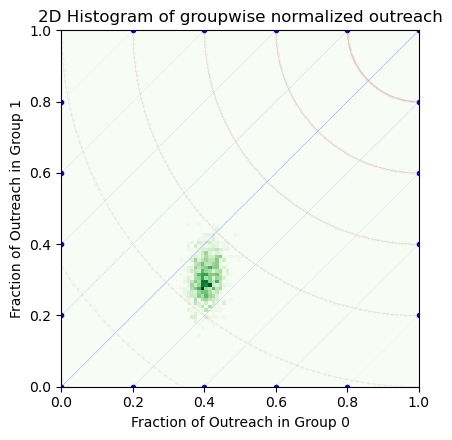

In [89]:
from plots.plot_2d import plot_seedset_joint_dist

plot_seedset_joint_dist(seedset,
                        time_horizon_factor=1,
                        bin_size=BIN_SIZE,
                        G=G,
                        node_feats=node_feats,
                        edge_prob=EDGE_PROB,
                        realizations=REALIZATIONS)

#### 7.1. Evaluate the new candidate seedset

In [90]:
least_impr = (seedset,
              seedset_reach_transport_score(seedset,
                                            G,
                                            node_feats,
                                            EDGE_PROB,
                                            ot_refs=ot_refs,
                                            time_horizon_scale=1,
                                            realizations=REALIZATIONS,
                                            bin_size=BIN_SIZE))
net_ot_score_hist = [least_impr[1]]

for iter_improvement in improvements:
    curr_seedset = iter_improvement[0]
    curr_ot_score = iter_improvement[1]

    net_ot_score_hist.append(curr_ot_score)

    if curr_ot_score < least_impr[1]:
        least_impr = deepcopy((curr_seedset, curr_ot_score))

print("Initial selection: ", seedset)
print("Best improvement: ", least_impr)

Initial selection:  ['10.1103/PhysRevLett.52.1583', '10.1103/PhysRevLett.49.957', '10.1103/PhysRevLett.67.937', '10.1103/PhysRevLett.53.722', '10.1103/PhysRevLett.60.2677', '10.1103/PhysRevLett.53.111', '10.1103/PhysRevLett.52.2103', '10.1103/PhysRevLett.55.912', '10.1103/PhysRevLett.69.2863', '10.1103/PhysRevLett.49.1545', '10.1103/PhysRevB.33.7647', '10.1103/PhysRevB.40.8745', '10.1103/PhysRevLett.66.1529', '10.1103/PhysRevLett.71.2401', '10.1103/PhysRevA.45.6056', '10.1103/PhysRevB.41.6870', '10.1103/PhysRevLett.67.1338', '10.1103/PhysRevB.46.9359', '10.1103/PhysRevLett.52.5', '10.1103/PhysRevLett.72.600', '10.1103/PhysRevLett.73.3331', '10.1103/PhysRevLett.64.705', '10.1103/PhysRevLett.73.2740', '10.1103/PhysRevLett.63.2291', '10.1103/PhysRevLett.63.2295', '10.1103/PhysRevB.57.9907', '10.1103/PhysRevLett.78.3233', '10.1103/PhysRevLett.55.2887', '10.1103/PhysRevB.31.1191', '10.1103/PhysRevB.50.15210', '10.1103/PhysRevLett.61.517', '10.1103/PhysRevLett.68.3460', '10.1103/PhysRevB.43.

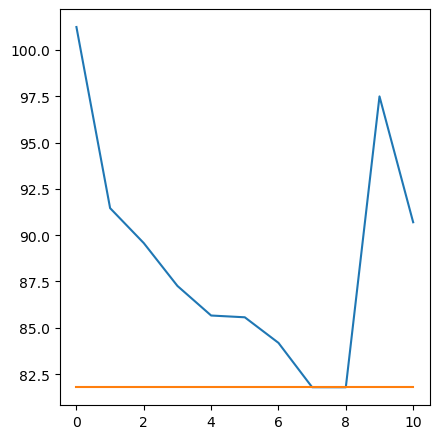

In [91]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(0, len(improvements) + 1, 1), net_ot_score_hist)
plt.plot(np.arange(0,
                   len(improvements) + 1, 1),
         [least_impr[1]] * (len(improvements) + 1))

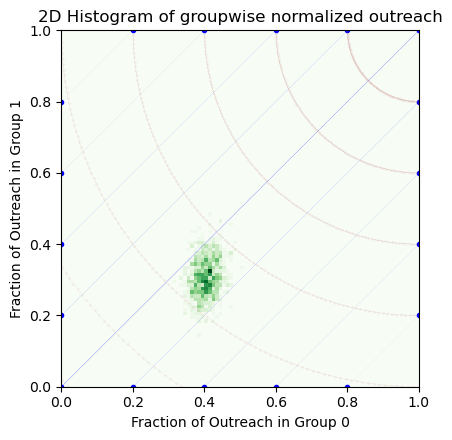

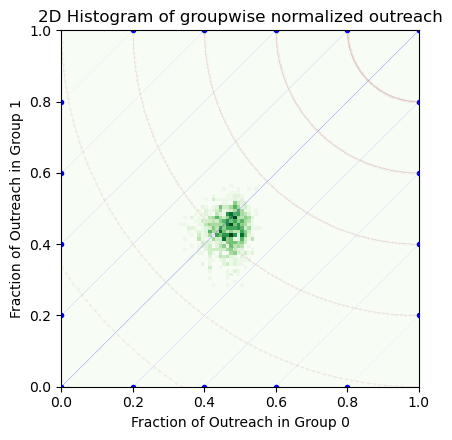

In [92]:
plot_seedset_joint_dist(seedset,
                        time_horizon_factor=1,
                        bin_size=BIN_SIZE,
                        G=G,
                        node_feats=node_feats,
                        edge_prob=EDGE_PROB,
                        realizations=REALIZATIONS)
new_seedset = least_impr[0]
# assert (len(list(set(new_seedset))) == len(new_seedset))
assert (set(seedset) != set(new_seedset))
plot_seedset_joint_dist(new_seedset,
                        time_horizon_factor=1,
                        bin_size=BIN_SIZE,
                        G=G,
                        node_feats=node_feats,
                        edge_prob=EDGE_PROB,
                        realizations=REALIZATIONS)

In [93]:
print("Original OT score: ", net_ot_score_hist[0])
print("Best found OT score: ", least_impr[1])

Original OT score:  101.24031378467743
Best found OT score:  81.7843192751726


#### 7.2. Evaluate the baseline fairness seedset selection ([Stoica et. al.](https://dl.acm.org/doi/10.1145/3366423.3380275))

['10.1103/PhysRevB.34.7851', '10.1103/PhysRevE.53.1021', '10.1103/PhysRevE.53.4754', '10.1103/PhysRevE.81.041106', '10.1103/PhysRevB.32.3075', '10.1103/PhysRevLett.62.708', '10.1103/PhysRevE.81.011129', '10.1103/PhysRevLett.64.303', '10.1103/PhysRevB.68.134442', '10.1103/PhysRevE.68.026123', '10.1103/PhysRevLett.59.2385', '10.1103/PhysRevLett.105.140601', '10.1103/PhysRevE.82.041102', '10.1103/PhysRevE.49.3930', '10.1103/PhysRevA.31.1971', '10.1103/PhysRevE.64.046129', '10.1103/PhysRevA.46.3243', '10.1103/PhysRevA.44.6202', '10.1103/PhysRevB.56.51', '10.1103/PhysRevLett.107.140404', '10.1103/PhysRevLett.66.802', '10.1103/PhysRevA.87.032108', '10.1103/PhysRevA.36.3427', '10.1103/PhysRevE.56.3927', '10.1103/PhysRevD.35.510', '10.1103/PhysRevB.55.5619', '10.1103/PhysRevA.44.5302', '10.1103/PhysRevA.55.941', '10.1103/PhysRevD.37.3505', '10.1103/PhysRevA.45.7104', '10.1103/PhysRevA.55.1695', '10.1103/PhysRevE.63.046105', '10.1103/PhysRevB.45.2950', '10.1103/PhysRevB.68.064204', '10.1103/Phy

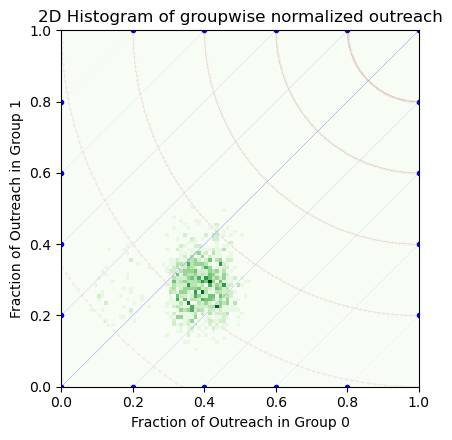

In [94]:
from early_seed_selection.fairness_aware import greedy_node_reach as fair_greedy_node_reach, node_degree as fair_node_degree

fair_baseline_seedset = fair_node_degree.propose_seedset(
    G,
    node_feats,
    NUM_SEEDS,
    EDGE_PROB,
    num_realizations=REALIZATIONS,
    min_fair_ratio=0.3,
    max_fair_ratio=0.7)

print(fair_baseline_seedset)
# print(seedset)

plot_seedset_joint_dist(fair_baseline_seedset,
                        time_horizon_factor=1,
                        bin_size=BIN_SIZE,
                        G=G,
                        node_feats=node_feats,
                        edge_prob=EDGE_PROB,
                        realizations=REALIZATIONS)

#### 7.3 Direct compare several outreaches [Interface]

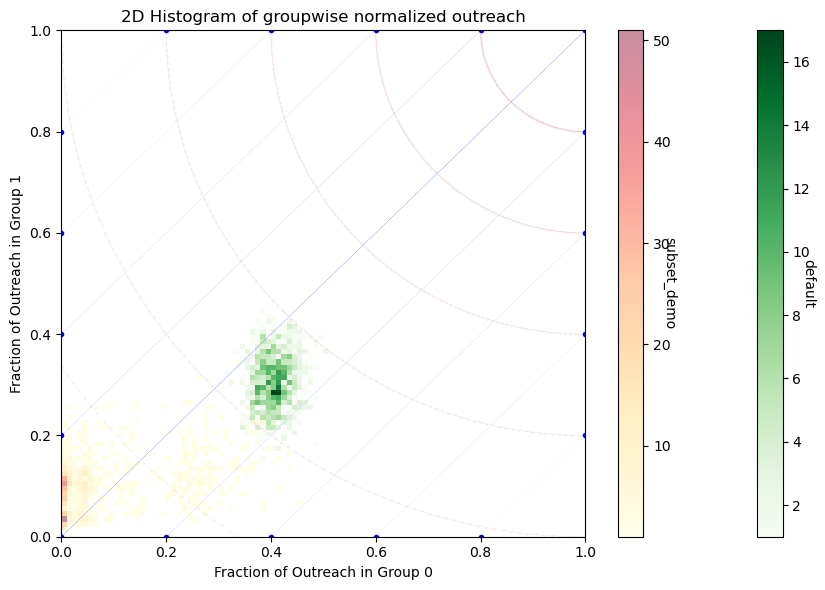

In [95]:
from plots.plot_2d import plot_several_seedsets_joint_dist, plot_seedset_joint_dist

demo_seedset = [
    '10.1103/PhysRevB.34.7851', '10.1103/PhysRevE.53.1021',
    '10.1103/PhysRevE.53.4754', '10.1103/PhysRevE.81.041106',
    '10.1103/PhysRevB.32.3075'
]

labelled_seedsets = {
    "default-Greens": seedset,
    "subset_demo-YlOrRd": demo_seedset,
}

plot_several_seedsets_joint_dist(labelled_seedsets,
                                 time_horizon_factor=1,
                                 bin_size=BIN_SIZE,
                                 G=G,
                                 node_feats=node_feats,
                                 edge_prob=EDGE_PROB,
                                 realizations=REALIZATIONS)

## Plots to explore Efficiency and Fairness Impacts

In [96]:
from utils.data_utils import load_graph_from_edgelist, load_graph_node_features
from utils.graph_utils import log_social_graph_data_summary
from early_seed_selection.node_centrality import greedy_node_reach as greedy_seed_selector

ds_string = "aps_ds"
G = load_graph_from_edgelist(
    PROJECT_ROOT + "/data/" + ds_string +
    "/graph_edges.csv")  # nodes are string, edges are between strings
G.graph["prop_max_diam"] = 30  # ficticious
node_feats = load_graph_node_features(
    PROJECT_ROOT + "/data/" + ds_string +
    "/graph_node_features.csv")  # node features are ints for now
assert set(G.nodes()) == set(node_feats.keys())
log_social_graph_data_summary(G, node_feats)
NUM_SEEDS = 50
EDGE_PROB = 0.1
REALIZATIONS = 1000

seedset = greedy_seed_selector.propose_seedset(G,
                                               node_feats,
                                               NUM_SEEDS,
                                               EDGE_PROB,
                                               num_realizations=REALIZATIONS)


In [97]:
from plots.compare_fairness_metrics import fairness_with_conduction

fairness_with_conduction(G,
                         node_feats,
                         seedset,
                         realizations=REALIZATIONS,
                         bin_size=BIN_SIZE,
                         fig_name="./point_vs_dist_dz_g")

## Comparing algorithms in E-f space [Interface]

({'default-Greens': 0.1200991412958626,
  'subset_demo-YlOrRd': 0.008188914910226386},
 {'default-Greens': 0.9161919191919192,
  'subset_demo-YlOrRd': 0.985030303030303})

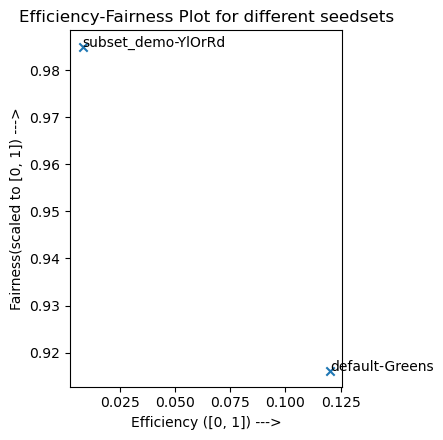

In [98]:
from plots.fairness_efficiency_space import fairness_efficiency_scatter_for_seedsets

fairness_efficiency_scatter_for_seedsets(G, node_feats, EDGE_PROB,
                                         labelled_seedsets, REALIZATIONS,
                                         BIN_SIZE)